In [9]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score 

In [29]:
#gold

gld = yf.Ticker('GLD')
gld = gld.history(period='max')
gld = gld[['Close', 'Open']]
gld.rename(columns={'Close': 'GLD_Close', 'Open': 'GLD_Open'}, inplace=True)

gld.head()

,GLD_Close,GLD_Open
Date,,
2004-11-18 00:00:00-05:00,44.380001,44.430000
2004-11-19 00:00:00-05:00,44.779999,44.490002
2004-11-22 00:00:00-05:00,44.950001,44.750000
2004-11-23 00:00:00-05:00,44.750000,44.880001
2004-11-24 00:00:00-05:00,45.049999,44.930000


In [30]:
#volatility index

vix = yf.Ticker('^VIX')
vix = vix.history(period='max')
vix = vix[['Close', 'Open']]
vix.rename(columns={'Close': 'VIX_Close', 'Open': 'VIX_Open'}, inplace=True)

vix.head()

,VIX_Close,VIX_Open
Date,,
1990-01-02 00:00:00-06:00,17.240000,17.240000
1990-01-03 00:00:00-06:00,18.190001,18.190001
1990-01-04 00:00:00-06:00,19.219999,19.219999
1990-01-05 00:00:00-06:00,20.110001,20.110001
1990-01-08 00:00:00-06:00,20.260000,20.260000


In [31]:
ticker = yf.Ticker('SPY')
ticker = ticker.history(period='max')
ticker.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
1993-01-29 00:00:00-05:00,24.543521,24.543521,24.421414,24.526077,1003200,0.0,0.0,0.0
1993-02-01 00:00:00-05:00,24.543525,24.700520,24.543525,24.700520,480500,0.0,0.0,0.0
1993-02-02 00:00:00-05:00,24.683061,24.770280,24.630729,24.752836,201300,0.0,0.0,0.0
1993-02-03 00:00:00-05:00,24.787745,25.031959,24.770301,25.014515,529400,0.0,0.0,0.0
1993-02-04 00:00:00-05:00,25.101722,25.171497,24.822620,25.119165,531500,0.0,0.0,0.0


In [32]:
# borrar las columnas que no necesito
del ticker['Dividends']
del ticker['Stock Splits']
del ticker['Capital Gains']

# renombrar
ticker.rename(columns={'Close': 'SPY_Close', 'Open': 'SPY_Open'}, inplace=True)
ticker.head()

,SPY_Open,High,Low,SPY_Close,Volume
Date,,,,,
1993-01-29 00:00:00-05:00,24.543521,24.543521,24.421414,24.526077,1003200
1993-02-01 00:00:00-05:00,24.543525,24.700520,24.543525,24.700520,480500
1993-02-02 00:00:00-05:00,24.683061,24.770280,24.630729,24.752836,201300
1993-02-03 00:00:00-05:00,24.787745,25.031959,24.770301,25.014515,529400
1993-02-04 00:00:00-05:00,25.101722,25.171497,24.822620,25.119165,531500


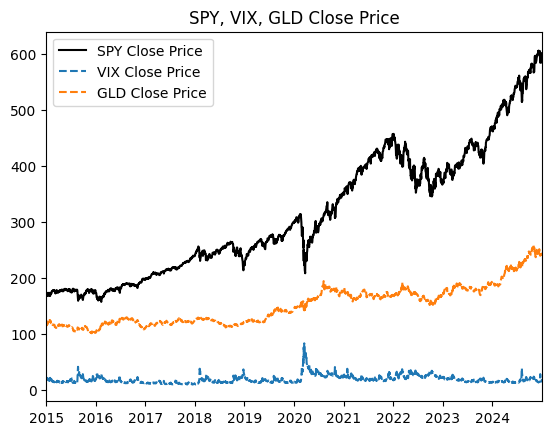

In [33]:
plt.plot(ticker.index, ticker['SPY_Close'], label='SPY Close Price', color='black')
plt.plot(vix.index, vix['VIX_Close'], label='VIX Close Price', linestyle='dashed')
plt.plot(gld.index, gld['GLD_Close'], label='GLD Close Price', linestyle='dashed')
plt.xlim([pd.Timestamp('2015-01-01'), pd.Timestamp('2025-01-01')])
plt.legend()
plt.title("SPY, VIX, GLD Close Price")
plt.show()

In [34]:
# Ensure all DataFrames have timezone-naive datetime index
ticker.index = pd.to_datetime(ticker.index).tz_localize(None)
vix.index = pd.to_datetime(vix.index).tz_localize(None)
gld.index = pd.to_datetime(gld.index).tz_localize(None)

# merge VIX
ticker = ticker.merge(vix, left_index=True, right_index=True, how="outer")

# merge GLD
ticker = ticker.merge(gld, left_index=True, right_index=True, how="outer")

# Forward-fill missing values
ticker.fillna(method="ffill", inplace=True)

print(ticker.head())

            SPY_Open  High  Low  SPY_Close  Volume  VIX_Close   VIX_Open  \
Date                                                                       
1990-01-02       NaN   NaN  NaN        NaN     NaN  17.240000  17.240000   
1990-01-03       NaN   NaN  NaN        NaN     NaN  18.190001  18.190001   
1990-01-04       NaN   NaN  NaN        NaN     NaN  19.219999  19.219999   
1990-01-05       NaN   NaN  NaN        NaN     NaN  20.110001  20.110001   
1990-01-08       NaN   NaN  NaN        NaN     NaN  20.260000  20.260000   

            GLD_Close  GLD_Open  
Date                             
1990-01-02        NaN       NaN  
1990-01-03        NaN       NaN  
1990-01-04        NaN       NaN  
1990-01-05        NaN       NaN  
1990-01-08        NaN       NaN  


C:\Users\Ramon\AppData\Local\Temp\ipykernel_9020\747948756.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ticker.fillna(method="ffill", inplace=True)


In [35]:
# target
ticker['Tomorrow'] = ticker['SPY_Close'].shift(-1) #tomorrow tiene el precio al cierre del siguiente dia
ticker.head()

,SPY_Open,High,Low,SPY_Close,Volume,VIX_Close,VIX_Open,GLD_Close,GLD_Open,Tomorrow
Date,,,,,,,,,,
1990-01-02,NaN,NaN,NaN,NaN,NaN,17.240000,17.240000,NaN,NaN,NaN
1990-01-03,NaN,NaN,NaN,NaN,NaN,18.190001,18.190001,NaN,NaN,NaN
1990-01-04,NaN,NaN,NaN,NaN,NaN,19.219999,19.219999,NaN,NaN,NaN
1990-01-05,NaN,NaN,NaN,NaN,NaN,20.110001,20.110001,NaN,NaN,NaN
1990-01-08,NaN,NaN,NaN,NaN,NaN,20.260000,20.260000,NaN,NaN,NaN


In [36]:
ticker['Target'] = (ticker['Tomorrow'] > ticker['SPY_Close']).astype(int) # 1 = el precio al cierre del dia siguiente es mayor
ticker.head()

,SPY_Open,High,Low,SPY_Close,Volume,VIX_Close,VIX_Open,GLD_Close,GLD_Open,Tomorrow,Target
Date,,,,,,,,,,,
1990-01-02,NaN,NaN,NaN,NaN,NaN,17.240000,17.240000,NaN,NaN,NaN,0
1990-01-03,NaN,NaN,NaN,NaN,NaN,18.190001,18.190001,NaN,NaN,NaN,0
1990-01-04,NaN,NaN,NaN,NaN,NaN,19.219999,19.219999,NaN,NaN,NaN,0
1990-01-05,NaN,NaN,NaN,NaN,NaN,20.110001,20.110001,NaN,NaN,NaN,0
1990-01-08,NaN,NaN,NaN,NaN,NaN,20.260000,20.260000,NaN,NaN,NaN,0


In [37]:
# sma for different timeframes
ticker['SMA_5'] = ticker['SPY_Close'].rolling(window=5).mean()
ticker['SMA_10'] = ticker['SPY_Close'].rolling(window=10).mean()   # 10-day SMA
ticker['SMA_20'] = ticker['SPY_Close'].rolling(window=20).mean()   
ticker['SMA_50'] = ticker['SPY_Close'].rolling(window=50).mean() 

In [38]:
ticker = ticker.loc['2015-01-01':].copy()
ticker.tail(20)

,SPY_Open,High,Low,SPY_Close,Volume,VIX_Close,VIX_Open,GLD_Close,GLD_Open,Tomorrow,Target,SMA_5,SMA_10,SMA_20,SMA_50
Date,,,,,,,,,,,,,,,
2025-01-10,585.880005,585.950012,578.549988,580.489990,73105000.0,19.540001,18.290001,248.210007,248.009995,581.390015,1,589.183997,590.121002,593.686172,592.272338
2025-01-13,575.770020,581.750000,575.349976,581.390015,47910100.0,19.190001,21.180000,245.740005,246.339996,582.190002,1,587.071997,588.126001,592.484555,592.303767
2025-01-14,584.359985,585.000000,578.349976,582.190002,48420600.0,18.709999,18.790001,247.029999,245.619995,592.780029,1,584.438000,586.844000,591.478912,592.386278
2025-01-15,590.330017,593.940002,589.200012,592.780029,56900200.0,16.120001,19.080000,248.880005,248.210007,591.640015,0,585.268005,587.300006,591.008749,592.907227
2025-01-16,594.169983,594.349976,590.929993,591.640015,43319700.0,16.600000,15.870000,250.600006,250.559998,597.580017,1,585.698010,587.856006,590.353021,593.357537
2025-01-17,596.960022,599.359985,595.609985,597.580017,58070600.0,15.970000,16.190001,249.270004,249.699997,603.049988,1,589.116016,589.150006,590.118875,593.951165
2025-01-21,600.669983,603.059998,598.669983,603.049988,42532900.0,15.060000,16.290001,253.130005,251.949997,606.440002,1,593.448010,590.260004,591.055704,594.516853
2025-01-22,605.919983,607.820007,605.359985,606.440002,48196000.0,15.100000,14.890000,254.429993,254.289993,609.750000,1,598.298010,591.368005,592.171005,594.864504
2025-01-23,605.799988,609.750000,605.520020,609.750000,41152100.0,15.020000,15.280000,254.070007,253.190002,607.969971,0,601.692004,593.480005,593.101004,595.187263


In [39]:
model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train = ticker.iloc[:-100]
test = ticker.iloc[-100:]

predictors = ['SPY_Close', 'SPY_Open', 'Volume', 'VIX_Close', 'VIX_Open', 'GLD_Close', 'GLD_Open',
               'SMA_10']

model.fit(train[predictors], train['Target'])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [40]:
# measures

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index) #numpy array to pandas series
print(preds.head())
print(preds.tail())
precision_score(test['Target'], preds)

Date
2024-09-16    1
2024-09-17    1
2024-09-18    1
2024-09-19    0
2024-09-20    0
dtype: int64
Date
2025-02-03    0
2025-02-04    0
2025-02-05    0
2025-02-06    0
2025-02-07    0
dtype: int64


0.7142857142857143

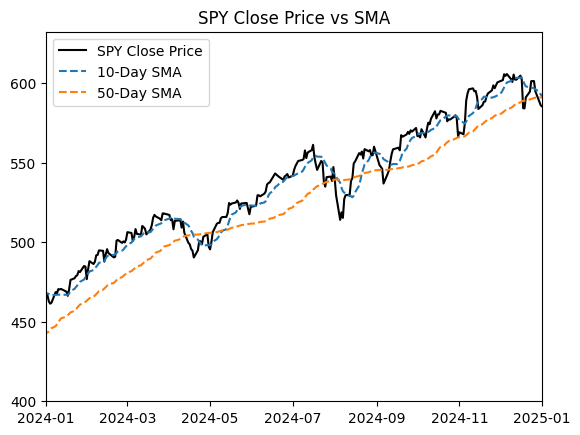

In [41]:
plt.plot(ticker.index, ticker['SPY_Close'], label='SPY Close Price', color='black')
plt.plot(ticker.index, ticker['SMA_10'], label='10-Day SMA', linestyle='dashed')
plt.plot(ticker.index, ticker['SMA_50'], label='50-Day SMA', linestyle='dashed')
plt.xlim([pd.Timestamp('2024-01-01'), pd.Timestamp('2025-01-01')])
plt.ylim([400, None])
plt.legend()
plt.title("SPY Close Price vs SMA")
plt.show()

In [42]:
# prediccion para el sig dia
next_day_prediction = model.predict(test[predictors])[0]  # Extract the prediction
print("Prediction for Tomorrow:", "UP" if next_day_prediction == 1 else "DOWN")

Prediction for Tomorrow: UP


<Axes: xlabel='Date'>

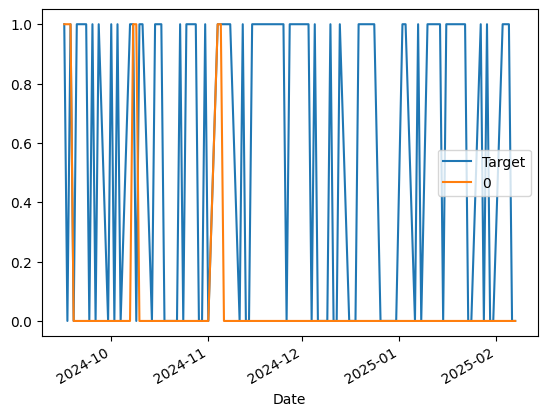

In [43]:
combined = pd.concat([test['Target'], preds], axis=1)
combined.plot()